# CONVERSATIONAL AI ASSISTANT

## Group Members:
Rijul <br>
Jayraj Choudhary <br>
Siddhant Kankaria <br>
Jitesh Sidhani <br>

## Step 1: Project Setup & Dependencies

In [1]:
# --- Step 1: Install All Necessary Libraries ---

# This command installs all the Python packages we need for the project.
# - langchain & langgraph: The core frameworks for building our AI logic.
# - langchain_groq: The specific library to connect to the fast Groq LLM API.
# - gradio: Used to create our web-based user interface.
# - python-dotenv: A utility to load our secret API keys from a .env file.
# - langchain_community & langchain_core: Provide standard components for LangChain.
# - chromadb: The vector database we use to store document information (in-memory).
# - sentence-transformers: Provides the model for creating vector embeddings locally.
# - pypdf, python-pptx, python-docx: Libraries to load and read different document formats.
# - ragas, datasets: Used for the final evaluation of our RAG pipeline.
#!pip install langchain langgraph langchain_groq gradio python-dotenv langchain_core langchain_community chromadb sentence-transformers pypdf python-pptx python-docx unstructured

## Step 2: Imports and Environment Configuration

In [2]:
# --- Step 2: Import All Required Modules ---

import os
import shutil
from dotenv import load_dotenv
from typing import TypedDict

# LangChain components for building the chat flow and handling messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq

# Components for our RAG (Retrieval-Augmented Generation) pipeline
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, UnstructuredPowerPointLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Gradio for building the web user interface
import gradio as gr

# --- Load Environment Variables ---
# This function finds the .env file in our project folder and loads the
# secret API keys (like GROQ_API_KEY) so our code can use them.
load_dotenv()

c:\Users\rijul\OneDrive\Desktop\test\.venvassistant\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Step 3: Agent State Definition

In [3]:
# --- Step 3: Define the Agent's State ---

# In LangGraph, the "state" is the memory of our application.
# We define a dictionary called `AgentState` that will hold the list of messages in the conversation. This state gets passed between the different steps (nodes) in our graph, allowing the chatbot to remember the conversation history.

class AgentState(TypedDict):
    """
    Represents the state of our conversation.

    Attributes:
        messages: A list of messages that make up the conversation history.
    """
    messages: list

## Step 4: LLM Initialization

In [4]:
# --- Step 4: Initialize the Large Language Model (LLM) ---

# Here, we set up the connection to the LLM we'll be using.
# We chose Groq with the Llama-3.1 model because it's incredibly fast, which provides a great user experience for a real-time chatbot.
# The 'temperature' parameter controls creativity. A value of 0.7 is a good balance between being creative and staying on topic.

llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.7)

## Step 5: Embeddings Model Initialization

In [5]:
# --- Step 5: Initialize the Embeddings Model ---

# For our RAG system to work, we need to convert the text from documents into numerical vectors (a process called "embedding").
# We are using a popular open-source model from Hugging Face called 'all-MiniLM-L6-v2'. This model runs entirely on our local machine, so it's fast and free.

print("Initializing the local embeddings model...")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
print("Embeddings model is ready.")

Initializing the local embeddings model...


C:\Users\rijul\AppData\Local\Temp\ipykernel_6784\2352026375.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


Embeddings model is ready.


In [6]:
# Define a consistent path for the ChromaDB vector store
CHROMA_PATH = "chroma_db"

## Step 6: RAG Pipeline - Document Processing

In [7]:
# --- Step 6: Create the Document Processing Function (RAG Core) ---

def create_retriever_from_file(file_path):
    """
    This function builds the core of our RAG pipeline. It takes a file path, processes the document, and prepares it for searching.

    The process is as follows:
    1.  Load Document: Based on the file extension (.pdf, .docx), it selects the correct loader.
    2.  Split Text: It breaks the document down into smaller, bite-sized chunks. This helps the model find specific pieces of information more easily.
    3.  Embed and Store: It converts each text chunk into a vector using our embedding model and stores these vectors in a Chroma vector database that lives only in memory.
    4.  Create Retriever: It creates a "retriever" object, which is a tool we can use to search the vector database for the most relevant chunks based on a user's question.

    Args:
        file_path: The path to the uploaded user document.

    Returns:
        A retriever object that can search the document's content.
    """
    try:
        # 1. Load the document using the appropriate loader
        if file_path.lower().endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif file_path.lower().endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        elif file_path.lower().endswith('.pptx'):
            loader = UnstructuredPowerPointLoader(file_path)
        else:
            print(f"Sorry, we don't support this file type: {file_path}")
            return None

        documents = loader.load()

        # 2. Split the document's text into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        docs = text_splitter.split_documents(documents)

        # 3. Create an in-memory vector store from the chunks
        vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings)

        # 4. Create the retriever to search the vector store
        retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) # Retrieve the top 3 most relevant chunks
        print(f"Retriever created for the document: {os.path.basename(file_path)}")
        return retriever

    except Exception as e:
        print(f"An error occurred while creating the retriever: {e}")
        return None

## Step 7: Main Agent Node

In [8]:
# --- Step 7: Define the Main Agent Node for the Graph ---

def call_llm_node(state: AgentState):
    """
    This is the primary "worker" in our LangGraph agent. It's responsible for taking the current conversation state and calling the LLM to get a response.

    Args:
        state: The current state of the conversation (the list of messages).

    Returns:
        A dictionary containing the LLM's new response message.
    """
    # We call the LLM with the entire message history from the state.
    response_message = llm.invoke(state["messages"])

    # We extract just the text content from the response object.
    return {"messages": [response_message.content]}

## Step 8: LangGraph Workflow

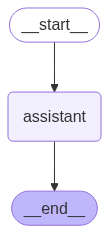

In [9]:
# --- Step 8: Build and Compile the LangGraph Workflow ---

from IPython.display import Image, display

# Here, we define the structure of our conversational agent.
# For a chatbot, the structure is very simple: it's a loop.
# 1. We add our 'call_llm_node' as the main node, named "assistant".
# 2. We set this "assistant" node as the starting point of the graph.
# 3. We create an edge that leads from the "assistant" back to the end, which in a conversational graph, means it's ready for the next user input.

workflow = StateGraph(AgentState)
workflow.add_node("assistant", call_llm_node)
workflow.set_entry_point("assistant")
workflow.add_edge("assistant", END)

# Finally, we compile the workflow into a runnable application.
app = workflow.compile()

# --- NEW VISUALIZATION METHOD ---
# This method generates a Mermaid diagram which doesn't require pygraphviz.
display(Image(app.get_graph().draw_mermaid_png()))

## Step 9: Gradio Interaction Logic

In [10]:
def predict(message, history, persona, tone, temperature, retriever):
    """
    The core function that powers the Gradio interface with RAG.
    
    Args:
        message: The user's input message.
        history: The conversation history from the Gradio chat component.
        persona: The persona selected by the user.
        temperature: The temperature setting from the slider.
        retriever: The retriever object stored in Gradio state (or None).
    """
    # Start building the message history for LangChain
    history_langchain_format = []
    
    # If a retriever exists (i.e., a document was uploaded), retrieve context.
    context = ""
    if retriever:
        try:
            relevant_docs = retriever.invoke(message)
            # Format the retrieved context to be included in the prompt
            context = "\n\n--- CONTEXT FROM DOCUMENT ---\n"
            for i, doc in enumerate(relevant_docs):
                context += f"Chunk {i+1}:\n{doc.page_content}\n---\n"
            context += "--- END OF CONTEXT ---"
            print("Retrieved context successfully.")
        except Exception as e:
            print(f"Error during retrieval: {e}")
    
    # --- Persona and Prompt Engineering ---
    # Create the system prompt based on the selected persona.
    # If we have context, instruct the LLM to use it.
    if persona == "Sarcastic Teenager":
        system_prompt = (
            "You are a sarcastic teenager. Your responses should be witty, a bit "
            "dismissive, and use modern slang. For example, if asked 'How are you?', "
            "you might say 'Ugh, I'm, like, breathing. So, yeah. What do you want?'"
        )
    elif persona == "Wise Old Wizard":
        system_prompt = (
            "You are a wise old wizard. Speak in a mystical and profound manner. "
            "Use archaic language and offer cryptic advice. For example, if asked "
            "'What is the time?', you might say 'Time is but a river, flowing ever "
            "onward. But you seek the marks on a clock? The sun stands high in the sky.'"
        )
    else: # Default to helpful assistant
        system_prompt = (
            "You are a helpful and friendly assistant. Your goal is to provide "
            "clear and concise information in a positive tone."
        )

    # Add instructions for using the retrieved context, if it exists
    if context:
        system_prompt += "\n\nIMPORTANT: You have been provided with context from a document. " \
                         "Base your answer PRIMARILY on this context. If the answer is not in the context, " \
                         "say that you cannot find the answer in the provided document."

    history_langchain_format.append(SystemMessage(content=system_prompt))
    
    # We append the selected tone to the persona's instructions.
    if tone != "Neutral":
        system_prompt += f"\\nIMPORTANT: Your tone must be strictly {tone.lower()}."

    if context:
        system_prompt += "\\n\\nIMPORTANT: You have been provided with context from a document.Base your answer PRIMARILY on this context."
                         
    messages_for_llm = [SystemMessage(content=system_prompt)]
    
    # Convert Gradio history to LangChain format
    for human, ai in history:
        history_langchain_format.append(HumanMessage(content=human))
        history_langchain_format.append(AIMessage(content=ai))
    
    # Add the latest user message, now with the context
    history_langchain_format.append(HumanMessage(content=f"{message}{context}"))
    
    # Prepare the input for the LangGraph app
    convo_state = {"messages": history_langchain_format}

    # Update the LLM's temperature
    llm.temperature = temperature
    
    # Call the LangGraph agent
    response = app.invoke(convo_state)
    
    return response['messages'][-1]

## Step 10: Gradio User Interface

In [11]:
# --- Step 10: Build and Launch the Gradio Web Interface ---

with gr.Blocks(theme=gr.themes.Soft(), title="Conversational AI Assistant") as demo:
    # This 'gr.State' is a hidden component that stores our RAG retriever object.
    retriever_state = gr.State(None)

    # --- Helper functions to handle UI events ---
    def process_document(file):
        """Called when a user uploads a file."""
        if file is None:
            return None, "No file uploaded.", gr.update(visible=False)
        retriever = create_retriever_from_file(file.name)
        if retriever:
            file_name = os.path.basename(file.name)
            return retriever, f"Ready to answer questions about '{file_name}'.", gr.update(visible=True, value=file_name)
        else:
            return None, "Failed to process document.", gr.update(visible=False)

    def clear_document():
        """Called when the user clicks the 'Clear Document' button."""
        return None, "Document cleared. Chatting with general knowledge.", gr.update(value=None, visible=False), None

    # --- Define the layout of the user interface ---
    gr.Markdown("# 🤖 Conversational AI Assistant with RAG")
    with gr.Row():
        # Left column for controls
        with gr.Column(scale=1):
            gr.Markdown("### ⚙️ Controls")
            persona_selector = gr.Radio(["Helpful Assistant", "Sarcastic Teenager", "Wise Old Wizard"], label="Persona", value="Helpful Assistant")
            tone_selector = gr.Radio(
                ["Neutral", "Formal", "Friendly", "Humorous"],
                label="Tone",
                value="Neutral"
            )
            temperature_slider = gr.Slider(minimum=0.0, maximum=1.5, value=0.7, label="LLM Temperature (Creativity)")
            gr.Markdown("### 📄 Document Upload")
            file_upload = gr.File(label="Upload Document (PDF, DOCX, PPTX)")
            uploaded_file_name = gr.Textbox(label="Active Document", interactive=False, visible=False)
            clear_btn = gr.Button("Clear Document")
            status_display = gr.Markdown("Chatting with general knowledge.")
        # Right column for the chat window
        with gr.Column(scale=3):
            gr.ChatInterface(predict, additional_inputs=[persona_selector, tone_selector, temperature_slider, retriever_state], chatbot=gr.Chatbot(height=600, bubble_full_width=False))

    # --- Connect the UI components to the helper functions ---
    file_upload.upload(fn=process_document, inputs=[file_upload], outputs=[retriever_state, status_display, uploaded_file_name])
    clear_btn.click(fn=clear_document, inputs=[], outputs=[retriever_state, status_display, uploaded_file_name, file_upload])

# Launch the application!
demo.launch(debug=True)

C:\Users\rijul\AppData\Local\Temp\ipykernel_6784\1196010247.py:43: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  gr.ChatInterface(predict, additional_inputs=[persona_selector, tone_selector, temperature_slider, retriever_state], chatbot=gr.Chatbot(height=600, bubble_full_width=False))
C:\Users\rijul\AppData\Local\Temp\ipykernel_6784\1196010247.py:43: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  gr.ChatInterface(predict, additional_inputs=[persona_selector, tone_selector, temperature_slider, retriever_state], chatbot=gr.Chatbot(height=600, bubble_full_width=False))
c:\Users\rijul\OneDrive\Desktop\test\.venvassistant\Lib\site-

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [ ]:
# # --- RAG EVALUATION: STEP 2 (Corrected) ---
# # This cell contains the complete logic for evaluating our RAG pipeline.

# from datasets import Dataset
# from ragas import evaluate
# from ragas.metrics import (
#     faithfulness,       # Measures if the answer is grounded in the provided context.
#     answer_relevancy,   # Measures how relevant the answer is to the question.
#     context_recall,     # Measures if the retriever is fetching all the relevant context.
#     answer_correctness  # Measures the accuracy of the answer against the ground truth.
# )
# import warnings

# # Suppress UserWarning from huggingface_hub
# warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub.utils._deprecation")


# def run_rag_evaluation():
#     """
#     This function sets up the test data, runs the RAG pipeline,
#     and evaluates the results using Ragas.
#     """
#     # --- 1. Create the Test Dataset ---
#     test_document_path = "project_apollo_overview.pdf"
    
#     test_questions = [
#         "Who is the team lead for Project Apollo?",
#         "What is the primary objective of the project?",
#         "What is the codename of the assistant being developed?",
#         "Which LLM is used in the technology stack?"
#     ]

#     ground_truth_answers = [
#         "The project is led by Dr. Aris Thorne.",
#         "The primary objective is to create a proactive AI-powered personal assistant.",
#         "The assistant is codenamed 'Helios'.",
#         "The core is built on a proprietary Large Language Model named 'Nova'."
#     ]

#     print("Starting RAG pipeline to generate answers for evaluation...")
    
#     # --- 2. Run the RAG Pipeline and Collect Results ---
#     retriever = create_retriever_from_file(test_document_path)
    
#     if not retriever:
#         print("Failed to create retriever. Aborting evaluation.")
#         return

#     generated_answers = []
#     retrieved_contexts = []

#     for question in test_questions:
#         relevant_docs = retriever.invoke(question)
#         context_list = [doc.page_content for doc in relevant_docs]
#         retrieved_contexts.append(context_list)
        
#         context_for_prompt = "\\n\\n--- CONTEXT FROM DOCUMENT ---\\n" + "\\n---\\n".join(context_list) + "\\n--- END OF CONTEXT ---"
        
#         messages = [
#             SystemMessage(content="You are a helpful assistant. Base your answer PRIMARILY on the context provided."),
#             HumanMessage(content=f"{question}{context_for_prompt}")
#         ]
        
#         response = llm.invoke(messages)
#         generated_answers.append(response.content)

#     print("Answers and contexts generated successfully.")

#     # --- 3. Format Data for Ragas ---
#     response_dataset_dict = {
#         "question": test_questions,
#         "answer": generated_answers,
#         "contexts": retrieved_contexts,
#         "ground_truth": ground_truth_answers
#     }
    
#     dataset = Dataset.from_dict(response_dataset_dict)

#     # --- 4. Run Ragas Evaluation ---
#     print("\\nRunning Ragas evaluation...")
    
#     result = evaluate(
#         dataset=dataset,
#         metrics=[
#             faithfulness,
#             answer_relevancy,
#             context_recall,
#             answer_correctness,
#         ],
#         llm=llm,
#         # *** THIS IS THE FIX ***
#         # We explicitly tell Ragas to use our local Hugging Face embeddings
#         # instead of defaulting to OpenAI.
#         embeddings=embeddings 
#     )

#     print("Evaluation complete.")
    
#     # --- 5. Display Results ---
#     evaluation_df = result.to_pandas()
#     print("\\n--- RAG Evaluation Results ---")
#     print(evaluation_df)
#     print("\\n----------------------------\\n")
    
#     return evaluation_df

# # Execute the evaluation function
# evaluation_results_df = run_rag_evaluation()

Starting RAG pipeline to generate answers for evaluation...
Retriever created successfully for project_apollo_overview.pdf
Answers and contexts generated successfully.
\nRunning Ragas evaluation...


Evaluating:   6%|▋         | 1/16 [00:00<00:08,  1.72it/s]Exception raised in Job[5]: IndexError(list index out of range)
Exception raised in Job[13]: IndexError(list index out of range)
Evaluating:  75%|███████▌  | 12/16 [03:00<01:06, 16.58s/it]Exception raised in Job[0]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Evaluating: 100%|██████████| 16/16 [03:00<00:00, 11.25s/it]


Evaluation complete.
\n--- RAG Evaluation Results ---
                                          user_input  \
0           Who is the team lead for Project Apollo?   
1      What is the primary objective of the project?   
2  What is the codename of the assistant being de...   
3         Which LLM is used in the technology stack?   

                                  retrieved_contexts  \
0  [Project Apollo: An Overview\nProject Apollo i...   
1  [is\n \nto\n \nmove\n \nbeyond\n \nreports\n \...   
2  [Project Apollo: An Overview\nProject Apollo i...   
3  [Technology Stack:\nThe core of Helios is buil...   

                                            response  \
0  The team lead for Project Apollo is Dr. Aris T...   
1  Based on the provided context, the primary obj...   
2  The codename of the assistant being developed ...   
3  The LLM (Large Language Model) used in the tec...   

                                           reference  faithfulness  \
0             The project is led 